# In The Mood For Love

Projeto inspirado pelo filme In The Mood For Love do diretor Wong Kar-Wai.

Passos:
1. Extrair trecho do filme e separar em cenas. Duas opções: utilizar o método do ffmpeg ou a biblioteca scenedetect.
2. Extrair frames das cenas para analisar imagem (hue, saturação...).
3. Extrair áudio das cenas e coletar informações como nível médio de áudio e silêncio.

Fazer funcionar antes para depois melhorar.
Pontos a melhorar: adicionar mais atributos de audio e de imagem, extrair mais de um frame por cena, otimizar detecção de cenas...

In [233]:
import pandas as pd 
import numpy as np 

In [254]:
from importlib import reload
import sys
sys.path.append('../src')

import scene_detection
import feature_extraction 
import visualization
import clustering 

reload(scene_detection)
reload(feature_extraction)
reload(visualization)
reload(clustering)

from scene_detection import detect_scene_low_resolution
from feature_extraction import audio_features, extract_frames, image_features, movement_features
from visualization import plot_rms_silence, plot_color_features, plot_movement, plot_cluster_timeline, plot_scatter_umap, plot_scatter_pca
from clustering import clustering 

In [235]:
video_name = 'fullMovie' 
file_extension = '.mp4' 
video_file =  video_name + file_extension 

df = pd.DataFrame() 
df = detect_scene_low_resolution(video_file) 

VideoManager is deprecated and will be removed.


Total de shots: 461


In [236]:
df = audio_features(video_file, df) 
df = extract_frames(video_file, df) 
df = image_features(df) 

# df = movement_features(video_file, df) 
# testar depois: usar lowres e ver se valores obtidos pelo original e lowres sao iguais 
# resultado: valores diferentes 

In [237]:
df.head()

,shot_id,hue_mean,hue_var,sat_mean,sat_var,val_mean,val_var,r_mean,r_var,g_mean,g_var,b_mean,b_var,start,end,duration,rms_mean,rms_std,silence_ratio,frame_path
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.866667,2.866667,0.000290,0.000474,0.887097,../data/frames/fullM_000_1.433.jpg
1,1,1.290360,62.679845,2.230100,389.307034,4.646810,700.689823,4.622418,694.808189,4.627525,696.863872,4.241653,587.145291,2.866667,10.333333,7.466667,0.000918,0.000983,0.534161,../data/frames/fullM_001_6.600.jpg
2,2,14.071744,2141.967465,204.088495,10154.128736,112.616738,713.361049,112.574157,708.917356,33.023680,4289.845148,33.232057,4289.405211,10.333333,12.600000,2.266667,0.000020,0.000005,1.000000,../data/frames/fullM_002_11.467.jpg
3,3,12.175712,1881.840662,168.523223,14367.451438,121.724119,989.191920,121.693258,986.518074,56.033568,6047.314430,56.212236,6037.387993,12.600000,14.733333,2.133333,0.022561,0.023716,0.206522,../data/frames/fullM_003_13.667.jpg
4,4,13.343797,2037.423121,223.095891,6864.817579,107.607857,501.351330,107.564405,496.391808,20.722944,2916.097235,20.938802,2922.445513,14.733333,19.866667,5.133333,0.024927,0.010684,0.000000,../data/frames/fullM_004_17.300.jpg


In [238]:
df.to_csv(f'../data/{video_name}.csv', index=False)

In [ ]:
# Visualization of audio, image and movement features 
# plot_rms_silence(df) 
plot_color_features(df)
# plot_movement(df)

# salvar gráfico de imagem em ../data como snippet_img_features.png

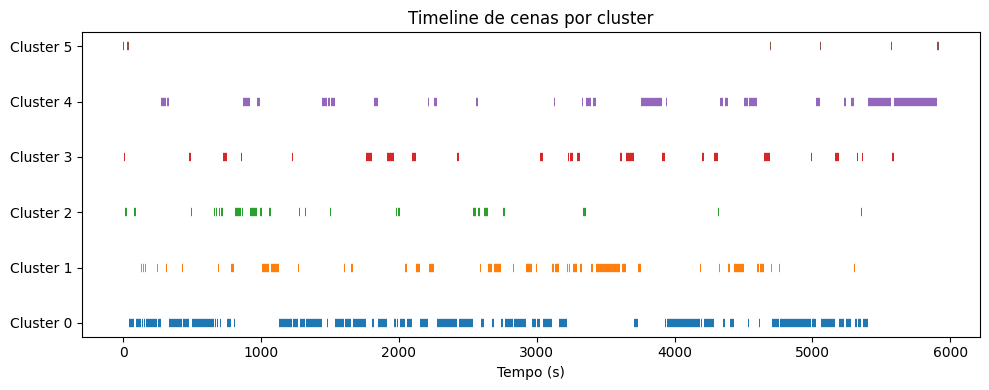

In [255]:
df = clustering(video_name, n_clusters=4)
# df = plot_scatter_pca(df)
# df = plot_scatter_umap(df)

plot_cluster_timeline(df)